## Overview

This notebook is a project done for Big Data Analytics module as part of the MSc curriculum. 
This notebook uses 2 datasets from the below provided links.
[Dataset 1](https://datacatalog.worldbank.org/dataset/covid-19-finance-sector-related-policy-responses)  contains the details of the types of government provided Covid-19 policies bought by the various income levels across the world for months between February and December of 2020. 
[Dataset 2](https://datahub.io/JohnSnowLabs/country-and-continent-codes-list#resource-country-and-continent-codes-list-csv) gives the deatils about the no:of covid-19 cases across various countries across the world for a certain month.
The goal of this project is to find useful analytic insights from the datsets.

Goals :
1. Find the country with maximum number of policy modifications 
2. Find the month with maximum number of modifications 
3. Is there any impact of the total number of cases on the number of modifications happened for the policy1
4. Which authority is popluar among various countries 
5. Which policy is preferred by thw lower middle income class globally
6. Derive a machine learning model to predict if the policy will be modified or not given a certain country, gdp and income level .

This project is implemented in Spark

In [0]:
import pyspark.sql.functions as f
import seaborn as sns
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

spark = SparkSession.builder.appName('BDA').getOrCreate()

In [0]:
!apt update
!apt install gcc python-dev libkrb5-dev -y
os.environ['SPARK_HOME'] = "/content/spark-3.0.2-bin-hadoop3.2" 
import pyspark
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

0% [Working]  Hit:1 https://repos.azul.com/zulu/deb stable InRelease
 0% [Connecting to archive.ubuntu.com (91.189.88.152)] [Connecting to security.u 0% [1 InRelease gpgv 3191 B] [Connecting to archive.ubuntu.com (91.189.88.152)]  Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
 0% [1 InRelease gpgv 3191 B] [Waiting for headers] [2 InRelease 14.2 kB/88.7 kB  0% [Waiting for headers] [2 InRelease 14.2 kB/88.7 kB 16%]  Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
  0% [2 InRelease 43.1 kB/88.7 kB 49%] 0% [3 InRelease gpgv 242 kB] [Waiting for headers] [2 InRelease 43.1 kB/88.7 kB  0% [3 InRelease gpgv 242 kB] [Waiting for headers]  0% [Waiting for headers] 0% [2 InRelease gpgv 88.7 kB] [Waiting for headers]  Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
 0% [2 InRelease gpgv 88.7 kB] [4 InRelease 14.2 kB/88.7 kB 16%]  0% [4 InRelease 15.6 kB/88.7 kB 18%]  0% [Working] 0% [4 InRelease gpgv 88.7 kB] [Waiting for headers]  0% [Waiting for headers]  Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
 0% [5 InRelease 2601 B/74.6 kB 3%]  0% [Working] 0% [5 InRelease gpgv 74.6 kB]  100% [Working]  Fetched 252 kB in 1s (224 kB/s)
Reading package lists... 0%Reading package lists... 0%Reading package lists... 0%Reading package lists... 6%Reading package lists... 6%Reading package lists... 6%Reading package lists... 6%Reading package lists... 55%Reading package lists... 57%Reading package lists... 57%Reading package lists... 58%Reading package lists... 58%Reading package lists... 69%Reading package lists... 69%Reading package lists... 71%Reading package lists... 71%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 90%Reading package lists... 90%Reading package lists... 92%Reading package lists... 92%Reading package lists... 98%Reading package lists... 98%Reading package lists... 98%Reading package lists... 98%Reading package lists... 99%Reading package lists... 99%Reading package lists... Done
Building dependency tree... 0%Building dependency tree... 0%Building dependency tree... 0%Building dependency tree... 50%Building dependency tree... 50%Building dependency tree 
Reading state information... 0%Reading state information... 0%Reading state information... Done
71 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... 0%Reading package lists... 0%Reading package lists... 0%Reading package lists... 6%Reading package lists... 6%Reading package lists... 6%Reading package lists... 6%Reading package lists... 54%Reading package lists... 57%Reading package lists... 57%Reading package lists... 58%Reading package lists... 58%Reading package lists... 69%Reading package lists... 69%Reading package lists... 71%Reading package lists... 71%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 81%Reading package lists... 90%Reading package lists... 90%Reading package lists... 92%Reading package lists... 92%Reading package lists... 98%Reading package lists... 98%Reading package lists... 98%Reading package lists... 98%Reading package lists... 99%Reading package lists... 99%Reading package lists... Done
Building dependency tree... 0%Building dependency tree... 0%Building dependency tree... 50%Building dependency tree... 50%Building dependency tree... 99%Building dependency tree 
Reading state information... 0%Reading state information... 0%Reading s

In [0]:
infer_schema = "True"
first_row_is_header = "True"

Policy_df = sqlContext.read.format("com.crealytics.spark.excel") \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .load("/FileStore/tables/covid_fci_data.xlsx")

Policy_df.show(10)

+----+--------------------+------------+-------------------+---------+-------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+-------------------+------------------------------+--------------+
 ID| Country Name|Country ISO3| Income Level|Authority| Date|Level 1 policy measures|Level 2 policy measures|Level 3 policy measures|Details of the measure| Reference| Termination Date|Modification of Parent Measure|Parent Measure|
+----+--------------------+------------+-------------------+---------+-------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+-------------------+------------------------------+--------------+
 1.0|China ...| CHN |Upper middle income| SUP |2020-02-01 00:00:00| Banking sector ...| Operational conti...| null| Require banks and...|http://www.gov.cn...| null| No | null|
 2.0|Canada ...| CAN |High income | CB |2020-03-13 00:00:00| Liquidity/funding...| Liquidity (incl F...| null| BoC also created ...|https://www.banko...|2020-10-31 00:00:00| No | null|
 3.0|China ...| CHN |Upper middle income| CB |2020-02-05 00:00:00| Banking sector ...| Integrity ...| Other integrity ...| The PBC has issue...| ...| null| No | null|
 4.0|Thailand ...| THA |Upper middle income| CB |2020-02-05 00:00:00| Liquidity/funding...| Policy rate ...| null| BOT cut its bench...|https://www.bot.o...| null| No | null|
 5.0|Russian Federatio...| RUS |Upper middle income| CB |2020-02-07 00:00:00| Liquidity/funding...| Policy rate ...| null| Policy rates were...|https://www.cnbc....| null| No | null|
 6.0|Belarus ...| BLR |Upper middle income| CB |2020-02-19 00:00:00| Liquidity/funding...| Policy rate ...| null| As of February 19...|https://www.nbrb....| null| No | null|
 7.0|Belarus ...| BLR |Upper middle income| CB |2020-02-19 00:00:00| Financial Markets...| Market functionin...| Ensure minimal fu...| The NBRB conducts...| ...| null| No | null|
 9.0|China ...| CHN |Upper middle income| CB |2020-02-17 00:00:00| Liquidity/funding...| Policy rate ...| null| Medium-term lendi...|https://www.reute...| null| No | null|
10.0|Indonesia ...| IDN |Lower middle income| CB |2020-02-20 00:00:00| Liquidity/funding...| Policy rate ...| null| BI cut its seven-...|https://www.bi.go...| null| No | null|
11.0|Japan ...| JPN |High income | MoF |2020-02-20 00:00:00| Banking sector ...| Support borrowers...| Other Support bor...| Packages of small...| ...| null| No | null|
+----+--------------------+------------+-------------------+---------+-------------------+-----------------------+-----------------------+-----------------------+----------------------+--------------------+-------------------+------------------------------+--------------+
only showing top 10 rows

The above df can be viewed better using the display function provided by databricks

In [0]:
display(Policy_df)

ID Country Name Country ISO3 Income Level Authority Date Level 1 policy measures Level 2 policy measures Level 3 policy measures Details of the measure Reference Termination Date Modification of Parent Measure Parent Measure 1.0 China CHN Upper middle income SUP 2020-02-01T00:00:00.000+0000 Banking sector Operational continuity null Require banks and insurance companies to ensure the safety, smoothness and efficiency of financial service; Provide fast path for afffected operations and businesses http://www.gov.cn/zhengce/zhengceku/2020-02/03/content_5474105.htm null No null 2.0 Canada CAN High income CB 2020-03-13T00:00:00.000+0000 Liquidity/funding Liquidity (incl FX)/ELA null BoC also created a Bankers Acceptance Purchase Facility to stabilize the interbank market and has intervened to do the same in repo and mortgage securitization markets. BAPF operations will continue until October 31, 2020 or financial market conditions improve in the Bank's judgement. https://www.bankofcanada.ca/markets/market-operations-liquidity-provision/market-operations-programs-and-facilities/bankers-acceptance-purchase-facility/ 2020-10-31T00:00:00.000+0000 No null 3.0 China CHN Upper middle income CB 2020-02-05T00:00:00.000+0000 Banking sector Integrity Other integrity The PBC has issued Notices on AML/CFT requirements in responding to the COVID-19 pandemic to all its branches on 5th Feb 2020. All branches of PBC should continue more pragmatic supervisory activities adapted to local situation and provide necessary guidance to local regulated entities when they face difficulties in meeting regulatory requirements. he PBC has issued Guidance on how to meet the AML/CFT requirements in responding to the COVID-19 pandemic to regulated entities on 5th Feb 2020. All regulated entities are encouraged to develop contingency program meeting the AML/CFT requirements by using the full range of RBA tools at their disposal. To support charitable activity and medical aid, simplified due diligence measures are allowed on low-risk services and products, but the STR of TF and the other high-risk areas should be maintained overall. null No null 4.0 Thailand THA Upper middle income CB 2020-02-05T00:00:00.000+0000 Liquidity/funding Policy rate null BOT cut its benchmark interest rate by 25 basis point, taking it to a record low 1% https://www.bot.or.th/English/PressandSpeeches/Press/2020/Pages/n0563.aspx null No null 5.0 Russian Federation RUS Upper middle income CB 2020-02-07T00:00:00.000+0000 Liquidity/funding Policy rate null Policy rates were reduced by 25 basis points to 6% on 02-07-2020 https://www.cnbc.com/2020/02/07/reuters-america-update-1-russia-lowers-key-rate-to-6-percent-says-more-cuts-still-possible-in-2020.html null No null 6.0 Belarus BLR Upper middle income CB 2020-02-19T00:00:00.000+0000 Liquidity/funding Policy rate null As of February 19, 2020, the rate on overnight credit â€“ from 10% to 9.75% and that on overnight deposit â€“ from 8% to 7.75%, the refinancing rate was cut from 9% to 8.75%. https://www.nbrb.by/engl/press/9898 null No null 7.0 Belarus BLR Upper middle income CB 2020-02-19T00:00:00.000+0000 Financial Markets/NBFI Market functioning Ensure minimal functionality in the primary and secondary markets The NBRB conducts foreign exchange interventions in additional volumes to lower market volatility. null No null 9.0 China CHN Upper middle income CB 2020-02-17T00:00:00.000+0000 Liquidity/funding Policy rate null Medium-term lending facility (MLF) rate cut by 10bps to 4.050% and injected RMB 200 billion (0.2 percent of GDP) of funds via MLF on Feb 17. https://www.reuters.com/article/us-china-economy-mlf/china-central-bank-cuts-one-year-mlf-rate-by-10-basis-points-to-support-virus-hit-economy-idUSKBN20B04B null No null 10.0 Indonesia IDN Lower middle income CB 2020-02-20T00:00:00.000+0000 Liquidity/funding Policy rate null BI cut its seven-day reverse repo rate by 25 basis points to 4.75 percent, Deposit Facility (DF) rates lowered 25 bps 

2.1 Select the required columns and then store it to another spark dataframe

In [0]:
Policy_df2 = Policy_df.select("Country ISO3","Income Level", "Authority","Level 1 policy measures","Level 2 policy measures","Level 3 policy measures","Modification of Parent Measure","Date")
Policy_df2.show(5)

+------------+-------------------+---------+-----------------------+-----------------------+-----------------------+------------------------------+-------------------+
Country ISO3| Income Level|Authority|Level 1 policy measures|Level 2 policy measures|Level 3 policy measures|Modification of Parent Measure| Date|
+------------+-------------------+---------+-----------------------+-----------------------+-----------------------+------------------------------+-------------------+
 CHN |Upper middle income| SUP | Banking sector ...| Operational conti...| null| No |2020-02-01 00:00:00|
 CAN |High income | CB | Liquidity/funding...| Liquidity (incl F...| null| No |2020-03-13 00:00:00|
 CHN |Upper middle income| CB | Banking sector ...| Integrity ...| Other integrity ...| No |2020-02-05 00:00:00|
 THA |Upper middle income| CB | Liquidity/funding...| Policy rate ...| null| No |2020-02-05 00:00:00|
 RUS |Upper middle income| CB | Liquidity/funding...| Policy rate ...| null| No |2020-02-07 00:00:00|
+------------+-------------------+---------+-----------------------+-----------------------+-----------------------+------------------------------+-------------------+
only showing top 5 rows

2.2. Drop the row, if all column values are null and also drop the level3 policy, because is there is no much data in that column that benefits us

In [0]:
Policy_df2.na.drop("all")
Policy_df3 = Policy_df2.drop("Level 3 policy measures")
Policy_df3.show(5)

+------------+-------------------+---------+-----------------------+-----------------------+------------------------------+-------------------+
Country ISO3| Income Level|Authority|Level 1 policy measures|Level 2 policy measures|Modification of Parent Measure| Date|
+------------+-------------------+---------+-----------------------+-----------------------+------------------------------+-------------------+
 CHN |Upper middle income| SUP | Banking sector ...| Operational conti...| No |2020-02-01 00:00:00|
 CAN |High income | CB | Liquidity/funding...| Liquidity (incl F...| No |2020-03-13 00:00:00|
 CHN |Upper middle income| CB | Banking sector ...| Integrity ...| No |2020-02-05 00:00:00|
 THA |Upper middle income| CB | Liquidity/funding...| Policy rate ...| No |2020-02-05 00:00:00|
 RUS |Upper middle income| CB | Liquidity/funding...| Policy rate ...| No |2020-02-07 00:00:00|
+------------+-------------------+---------+-----------------------+-----------------------+------------------------------+-------------------+
only showing top 5 rows

2.3. Rename the column names without spaces, so as to easily use SQL

In [0]:
# change the column names
Policy_df3 = Policy_df3.withColumnRenamed("Country ISO3","Country_code").withColumnRenamed("Level 1 policy measures","Level_1")  
Policy_df3 = Policy_df3.withColumnRenamed("Level 2 policy measures","Level_2").withColumnRenamed("Modification of Parent Measure","Modified")
Policy_df3.show(5)

+------------+-------------------+---------+--------------------+--------------------+---------+-------------------+
Country_code| Income Level|Authority| Level_1| Level_2| Modified| Date|
+------------+-------------------+---------+--------------------+--------------------+---------+-------------------+
 CHN |Upper middle income| SUP |Banking sector ...|Operational conti...|No |2020-02-01 00:00:00|
 CAN |High income | CB |Liquidity/funding...|Liquidity (incl F...|No |2020-03-13 00:00:00|
 CHN |Upper middle income| CB |Banking sector ...|Integrity ...|No |2020-02-05 00:00:00|
 THA |Upper middle income| CB |Liquidity/funding...|Policy rate ...|No |2020-02-05 00:00:00|
 RUS |Upper middle income| CB |Liquidity/funding...|Policy rate ...|No |2020-02-07 00:00:00|
+------------+-------------------+---------+--------------------+--------------------+---------+-------------------+
only showing top 5 rows

2.4. Extract the month from the date column

In [0]:
Policy_df3 = Policy_df3.withColumn('Month',f.month(f.to_timestamp('Date', 'dd/MM/yyyy')))
Policy_df3 = Policy_df3.drop("Date")
Policy_df3.show(5)

+------------+-------------------+---------+--------------------+--------------------+---------+-----+
Country_code| Income Level|Authority| Level_1| Level_2| Modified|Month|
+------------+-------------------+---------+--------------------+--------------------+---------+-----+
 CHN |Upper middle income| SUP |Banking sector ...|Operational conti...|No | 2|
 CAN |High income | CB |Liquidity/funding...|Liquidity (incl F...|No | 3|
 CHN |Upper middle income| CB |Banking sector ...|Integrity ...|No | 2|
 THA |Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2|
 RUS |Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2|
+------------+-------------------+---------+--------------------+--------------------+---------+-----+
only showing top 5 rows

2.5. Trim the white space after the country code

In [0]:
Policy_df3 = Policy_df3.withColumn('Country_codes', rtrim(Policy_df3.Country_code))
Policy_df3 = Policy_df3.drop("Country_code")
Policy_df3.show(10)

+-------------------+---------+--------------------+--------------------+---------+-----+-------------+
 Income Level|Authority| Level_1| Level_2| Modified|Month|Country_codes|
+-------------------+---------+--------------------+--------------------+---------+-----+-------------+
Upper middle income| SUP |Banking sector ...|Operational conti...|No | 2| CHN|
High income | CB |Liquidity/funding...|Liquidity (incl F...|No | 3| CAN|
Upper middle income| CB |Banking sector ...|Integrity ...|No | 2| CHN|
Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2| THA|
Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2| RUS|
Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2| BLR|
Upper middle income| CB |Financial Markets...|Market functionin...|No | 2| BLR|
Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 2| CHN|
Lower middle income| CB |Liquidity/funding...|Policy rate ...|No | 2| IDN|
High income | MoF |Banking sector ...|Support borrowers...|No | 2| JPN|
+-------------------+---------+--------------------+--------------------+---------+-----+-------------+
only showing top 10 rows

2.6 Use string indexing to convert categorical value "Modified" to numeric values

In [0]:
indexer = StringIndexer(inputCol="Modified", outputCol="Modification_Index")
Policy_df3 = indexer.fit(Policy_df3).transform(Policy_df3)

2.7 Group by the sum of modification after the string indexer

In [0]:
Policy_df3 = Policy_df3.groupBy("Month","Country_codes",'Income Level','Authority','Level_1',"Level_2","Modified").sum("Modification_Index")
Policy_df3.sort("Month").show(15)

+-----+-------------+-------------------+---------+--------------------+--------------------+---------+-----------------------+
Month|Country_codes| Income Level|Authority| Level_1| Level_2| Modified|sum(Modification_Index)|
+-----+-------------+-------------------+---------+--------------------+--------------------+---------+-----------------------+
 2| IDN|Lower middle income| CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| GMB|Low income | CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| BLR|Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| TUR|Upper middle income| Other|Financial Markets...|Market functionin...|No | 0.0|
 2| THA|Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| KHM|Lower middle income| Other|Banking sector ...|Support borrowers...|No | 0.0|
 2| JPN|High income | MoF |Banking sector ...|Support borrowers...|No | 0.0|
 2| UGA|Low income | Other|Payment systems ...|Promoting and ens...|No | 0.0|
 2| PHL|Lower middle income| CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| RUS|Upper middle income| CB |Liquidity/funding...|Policy rate ...|No | 0.0|
 2| BLR|Upper middle income| CB |Financial Markets...|Market functionin...|No | 0.0|
 2| CHN|Upper middle income| SUP |Banking sector ...|Operational conti...|No | 0.0|
 2| MYS|Upper middle income| CB |Financial Markets...|Market functionin...|No | 0.0|
 2| BRA|Upper middle income| CB |Liquidity/funding...|Liquidity (incl F...|No | 0.0|
 2| MYS|Upper middle income| CB |Banking sector ...|Support borrowers...|No | 0.0|
+-----+-------------+-------------------+---------+--------------------+--------------------+---------+-----------------------+
only showing top 15 rows

2.8 Checking for missing values,if any we should replace them with relevant data

In [0]:
Policy_df3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Policy_df3.columns]).show()
#Inference: we have no missing values in any of the columns we are intending to use as features

+-----+-------------+------------+---------+-------+-------+--------+-----------------------+
Month|Country_codes|Income Level|Authority|Level_1|Level_2|Modified|sum(Modification_Index)|
+-----+-------------+------------+---------+-------+-------+--------+-----------------------+
 0| 0| 0| 0| 0| 0| 0| 0|
+-----+-------------+------------+---------+-------+-------+--------+-----------------------+

Now we have the first df ready apart from one-hot encoding and vector assembler. Let us load the second dataset and do the preprocessing. 
We will do the later 2 stages of pipeline after merging both the dfs together. 
so let us preprocess the second df which contains the number of covid cases per country.

In [0]:
Country_wise = (sqlContext.read.format("csv").
  option("header", "true").
  option("nullValue", "NA").
  option("inferSchema", True).
  load("/FileStore/tables/Covid_regionWise.csv"))

Country_wise.show(5)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f1ac0900ef0>
Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/ml/wrapper.py", line 42, in __del__
 if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'
Exception ignored in: <function JavaWrapper.__del__ at 0x7f1ac0900ef0>
Traceback (most recent call last):
 File "/databricks/spark/python/pyspark/ml/wrapper.py", line 42, in __del__
 if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'
+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+---------+-----------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------------------------+----------------+-----------+------------------+----------+-------------+-------------+--------------+---------------+---------------------+-------------------+--------------+------------+----------------------+--------------------------+---------------+-----------------------+
iso_code|continent| location| date|total_cases|new_cases|new_cases_smoothed|total_deaths|new_deaths|new_deaths_smoothed|total_cases_per_million|new_cases_per_million|new_cases_smoothed_per_million|total_deaths_per_million|new_deaths_per_million|new_deaths_smoothed_per_million|reproduction_rate|icu_patients|icu_patients_per_million|hosp_patients|hosp_patients_per_million|weekly_icu_admissions|weekly_icu_admissions_per_million|weekly_hosp_admissions|weekly_hosp_admissions_per_million|new_tests|total_tests|total_tests_per_thousand|new_tests_per_thousand|new_tests_smoothed|new_tests_smoothed_per_thousand|positive_rate|tests_per_case|tests_units|total_vaccinations|people_vaccinated|people_fully_vaccinated|new_vaccinations|new_vaccinations_smoothed|total_vaccinations_per_hundred|people_vaccinated_per_hundred|people_fully_vaccinated_per_hundred|new_vaccinations_smoothed_per_million|stringency_index| population|population_density|median_age|aged_65_older|aged_70_older|gdp_per_capita|extreme_poverty|cardiovasc_death_rate|diabetes_prevalence|female_smokers|male_smokers|handwashing_facilities|hospital_beds_per_thousand|life_expectancy|human_development_index|
+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+---------+-----------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+-------------------------------------+----------------+-----------+------------------+----------+-------------+-------------+--------------+

This probably looks clumsy because of the large number of columns in the dataset. we can use the display command to view better as a table and decide which columns do we need

In [0]:
display(Country_wise)

iso_code continent location date total_cases new_cases new_cases_smoothed total_deaths new_deaths new_deaths_smoothed total_cases_per_million new_cases_per_million new_cases_smoothed_per_million total_deaths_per_million new_deaths_per_million new_deaths_smoothed_per_million reproduction_rate icu_patients icu_patients_per_million hosp_patients hosp_patients_per_million weekly_icu_admissions weekly_icu_admissions_per_million weekly_hosp_admissions weekly_hosp_admissions_per_million new_tests total_tests total_tests_per_thousand new_tests_per_thousand new_tests_smoothed new_tests_smoothed_per_thousand positive_rate tests_per_case tests_units total_vaccinations people_vaccinated people_fully_vaccinated new_vaccinations new_vaccinations_smoothed total_vaccinations_per_hundred people_vaccinated_per_hundred people_fully_vaccinated_per_hundred new_vaccinations_smoothed_per_million stringency_index population population_density median_age aged_65_older aged_70_older gdp_per_capita extreme_poverty cardiovasc_death_rate diabetes_prevalence female_smokers male_smokers handwashing_facilities hospital_beds_per_thousand life_expectancy human_development_index AFG Asia Afghanistan 2020-02-24 1.0 1.0 null null null null 0.026 0.026 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-02-25 1.0 0.0 null null null null 0.026 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-02-26 1.0 0.0 null null null null 0.026 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-02-27 1.0 0.0 null null null null 0.026 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-02-28 1.0 0.0 null null null null 0.026 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-02-29 1.0 0.0 0.143 null null 0.0 0.026 0.0 0.004 null null 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.33 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-03-01 1.0 0.0 0.143 null null 0.0 0.026 0.0 0.004 null null 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null 27.78 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-03-02 1.0 0.0 0.0 null null 0.0 0.026 0.0 0.0 null null 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null 27.78 3.8928341E7 54.422 18.6 2.581 1.337 1803.987 null 597.029 9.59 null null 37.746 0.5 64.83 0.511 AFG Asia Afghanistan 2020-03-03 2.0 1.0 0.143 null null 0.0 0.051 0.026 0.004 null null 0.0 null null null null null null null null null null null null null null null null null null null null null null null null null null null 27

We will use the month from date column and also the no:of total cases and check whether it effected the modification of the initial policy from df1. 

4.1 Select the required columns and then store it to another spark dataframe using SQL this time

In [0]:
# Create a view or table

temp_table_name = "country_wise_table"
Country_wise.createOrReplaceTempView(temp_table_name)

Country_wise = sqlContext.sql('SELECT iso_code,date,continent,total_cases_per_million,gdp_per_capita FROM country_wise_table')
Country_wise.show(10)

+--------+----------+---------+-----------------------+--------------+
iso_code| date|continent|total_cases_per_million|gdp_per_capita|
+--------+----------+---------+-----------------------+--------------+
 AFG|2020-02-24| Asia| 0.026| 1803.987|
 AFG|2020-02-25| Asia| 0.026| 1803.987|
 AFG|2020-02-26| Asia| 0.026| 1803.987|
 AFG|2020-02-27| Asia| 0.026| 1803.987|
 AFG|2020-02-28| Asia| 0.026| 1803.987|
 AFG|2020-02-29| Asia| 0.026| 1803.987|
 AFG|2020-03-01| Asia| 0.026| 1803.987|
 AFG|2020-03-02| Asia| 0.026| 1803.987|
 AFG|2020-03-03| Asia| 0.051| 1803.987|
 AFG|2020-03-04| Asia| 0.103| 1803.987|
+--------+----------+---------+-----------------------+--------------+
only showing top 10 rows

4.2. Extract the month from the date column

In [0]:
Country_wise = Country_wise.withColumn("Month", month("date").alias("year"))
Country_wise = Country_wise.drop("date")
Country_wise.show(5)

+--------+---------+-----------------------+--------------+-----+
iso_code|continent|total_cases_per_million|gdp_per_capita|Month|
+--------+---------+-----------------------+--------------+-----+
 AFG| Asia| 0.026| 1803.987| 2|
 AFG| Asia| 0.026| 1803.987| 2|
 AFG| Asia| 0.026| 1803.987| 2|
 AFG| Asia| 0.026| 1803.987| 2|
 AFG| Asia| 0.026| 1803.987| 2|
+--------+---------+-----------------------+--------------+-----+
only showing top 5 rows

4.3. Groupby the sum of total number of cases on month, country and gdp . Rename "iso_code" to "Country_codes"

In [0]:
Country_wise = Country_wise.groupBy("Month","iso_code","gdp_per_capita").sum("total_cases_per_million")
Country_wise = Country_wise.withColumnRenamed("iso_code","Country_codes")

4.4. Sort in ascending order of the month and drop the row, if any column has null values

In [0]:
Country_wise1 = Country_wise.sort("Month").na.drop("any").show(15)

+-----+-------------+--------------+----------------------------+
Month|Country_codes|gdp_per_capita|sum(total_cases_per_million)|
+-----+-------------+--------------+----------------------------+
 1| CHL| 22767.037| 1080858.188|
 1| AFG| 1803.987| 42851.01800000001|
 1| ALB| 11803.431| 725610.884|
 1| BRB| 16978.068| 112544.41100000001|
 1| BTN| 8708.597| 32780.725|
 1| COL| 13254.949| 1147233.437|
 1| CRI| 15524.995| 1115211.985|
 1| AUS| 44648.71| 34864.86899999999|
 1| CYP| 32415.132| 995650.184|
 1| BEN| 2064.236| 8895.008999999998|
 1| COG| 4881.406| 42118.90700000002|
 1| BEL| 42658.576| 1810548.251|
 1| BFA| 1703.102| 13199.89|
 1| DZA| 13913.839| 73254.08200000001|
 1| TCD| 1768.153| 5289.219999999999|
+-----+-------------+--------------+----------------------------+
only showing top 15 rows

5.1. We will merge both the datsets on the country and month field we need the common rows in bothe dfs hence we need inner join and display the merged df

In [0]:
Merged_df = Policy_df3.join(Country_wise, on=['Country_codes', 'Month'],how= "inner")
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

Data visualization can help us infer many hidden trends and patterns in our data. Databricks provides inbuilt functions for these kind of visualisation. This can be done using the plot options while displayin the dataframe. 
Let us first check which month has the maximum modification our the policy from the parent policy.

6.1. Visualise the number of modifications per country using the world mao feature in databricks. The count is also visible if we hover over each country

In [0]:
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

6.1 INFERENCE: It is visible that USA is the country with maximum no:of modifications

6.2. Check if we can find any pattern between the no: of policy modification and the month

In [0]:
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

6.2 INFERENCE :  The maximum of policy modifications has hapened in the months 4 and 6, ie; April and June. But there is no pattern found globally.

6.3. Let us check if the modification in a country is dependant on the number of covid- cases in that country. Ploting the modification per coutry per month and comparing it with another plot of total number of cases in each country against month will give us an idea. Let us check if our hypotheisi holds true.

In [0]:
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

6.3 INFERENCE: Taking major countries powers such as China, Italy, USA, UK, Mexico, Afghanistan, Egypt, Turkey into consideration. We can infer the following with Country and month with max modification respectively

China 6, Italy 8, USA 6, UK 7, Mexico 4, Afghanistan 5, Egypt 6, Turkey 8

plot of total number of cases in each country against month

In [0]:
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

6.4 INFERENCE: Taking major countries powers such as China, Italy, USA, UK, Mexico, Afghanistan, Egypt, Turkey into consideration. We can infer the following with Country and month with max no:of Covid cases respectively

China 2, Italy 9, USA 10, UK 9, Mexico 9, Afghanistan 5, Egypt 11, Turkey 2

In [0]:
display(Merged_df)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949 577348.9020000001 AUS 5 High income SUP Banking sector Prudential No 0.0 44648.71 8534.357 CHN 5 Upper middle income SUP Banking sector Prudential No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income GOV Financial Markets/NBFI Market functioning No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 15308.712 1810.0729999999999 CHN 5 Upper middle income CB Banking sector Crisis management No 0.0 15308.712 1810.0729999999999 CAN 5 High income GOV Insolvency Amending bankruptcy filing obligations No 0.0 44017.591 62787.083 CAN 5 High income Other Financial Markets/NBFI Public debt management Extension 1.0 44017.591 62787.083 CAN 5 High income MoF Banking sector Support borrowers No 0.0 44017.591 62787.083 CAN 5 High income SUP Financial Markets/NBFI NBFI No 0.0 44017.591 62787.083 CAN 5 High income GOV Banking sector Prudential No 0.0 44017.591 62787.083 CAN 5 High income Other Banking sector Prudential No 0.0 44017.591 62787.083 ARM 5 Upper middle income CB Banking sector Support borrowers No 0.0 8787.58 51108.011 ARM 5 Upper middle income CB Banking sector Prudential No

INFERENCE:  There is no impact of total number of cases per month on the number of modifications happened on parent policy of policy 1

6.5.Drop null rows from the merged dataset

In [0]:
Merged_df = Merged_df.na.drop("all")
Merged_df.count() 

Out[87]: 2183

7.1 Use string indexer to convert categorical values to numeric values

In [0]:
#convert to string indexer values
from pyspark.ml import Pipeline
categorical_columns= ['Country_codes', 'Level_1',"Authority","Income Level","Month","gdp_per_capita","sum(total_cases_per_million)","sum(Modification_Index)"]

# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]
Merged_df = Merged_df.na.drop(subset=["gdp_per_capita","sum(total_cases_per_million)"])
pipeline = Pipeline(stages=indexers)
model = pipeline.fit(Merged_df)
df4 =  model.transform(Merged_df)
display(df4) 

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) Country_codes_indexed Level_1_indexed Authority_indexed Income Level_indexed Month_indexed gdp_per_capita_indexed sum(total_cases_per_million)_indexed sum(Modification_Index)_indexed ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 4.0 0.0 0.0 1.0 5.0 4.0 524.0 1.0 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 83.0 0.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 83.0 2.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 83.0 3.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 83.0 1.0 0.0 3.0 0.0 85.0 235.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 86.0 2.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 86.0 0.0 1.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 86.0 3.0 3.0 2.0 0.0 90.0 151.0 0.0 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 119.0 0.0 4.0 2.0 2.0 131.0 539.0 0.0 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 28.0 1.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 28.0 3.0 0.0 2.0 2.0 28.0 215.0 0.0 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 2.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 1.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 41.0 2.0 0.0 0.0 1.0 41.0 127.0 0.0 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 2.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949

7.2 find the Authority popular in each country

In [0]:
display(df4)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) Country_codes_indexed Level_1_indexed Authority_indexed Income Level_indexed Month_indexed gdp_per_capita_indexed sum(total_cases_per_million)_indexed sum(Modification_Index)_indexed ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 4.0 0.0 0.0 1.0 5.0 4.0 524.0 1.0 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 83.0 0.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 83.0 2.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 83.0 3.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 83.0 1.0 0.0 3.0 0.0 85.0 235.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 86.0 2.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 86.0 0.0 1.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 86.0 3.0 3.0 2.0 0.0 90.0 151.0 0.0 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 119.0 0.0 4.0 2.0 2.0 131.0 539.0 0.0 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 28.0 1.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 28.0 3.0 0.0 2.0 2.0 28.0 215.0 0.0 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 2.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 1.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 41.0 2.0 0.0 0.0 1.0 41.0 127.0 0.0 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 2.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949

INFERENCE: The authority most popular in the Turkey, India are RES

7.3 Find if type of policy1 depends on the income level

In [0]:
display(df4)

Country_codes Month Income Level Authority Level_1 Level_2 Modified sum(Modification_Index) gdp_per_capita sum(total_cases_per_million) Country_codes_indexed Level_1_indexed Authority_indexed Income Level_indexed Month_indexed gdp_per_capita_indexed sum(total_cases_per_million)_indexed sum(Modification_Index)_indexed ARG 9 Upper middle income CB Banking sector Prudential Extension 1.0 18933.907 388221.71300000005 4.0 0.0 0.0 1.0 5.0 4.0 524.0 1.0 BFA 3 Low income CB Banking sector Support borrowers No 0.0 1703.102 90.947 83.0 0.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Financial Markets/NBFI Market functioning No 0.0 1703.102 90.947 83.0 2.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 1703.102 90.947 83.0 3.0 0.0 3.0 0.0 85.0 235.0 0.0 BFA 3 Low income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 1703.102 90.947 83.0 1.0 0.0 3.0 0.0 85.0 235.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 DZA 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 13913.839 109.986 87.0 1.0 0.0 1.0 0.0 82.0 318.0 0.0 CMR 3 Lower middle income CB Financial Markets/NBFI Public debt management No 0.0 3364.926 40.19200000000001 86.0 2.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income SUP Banking sector Prudential No 0.0 3364.926 40.19200000000001 86.0 0.0 1.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Policy rate No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3364.926 40.19200000000001 86.0 1.0 0.0 2.0 0.0 90.0 151.0 0.0 CMR 3 Lower middle income Other Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3364.926 40.19200000000001 86.0 3.0 3.0 2.0 0.0 90.0 151.0 0.0 AGO 5 Lower middle income MoF Banking sector Support borrowers No 0.0 5819.495 49.86600000000001 119.0 0.0 4.0 2.0 2.0 131.0 539.0 0.0 BGD 5 Lower middle income CB Banking sector Support borrowers No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 3523.984 4440.545 28.0 1.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Banking sector Prudential No 0.0 3523.984 4440.545 28.0 0.0 0.0 2.0 2.0 28.0 215.0 0.0 BGD 5 Lower middle income CB Payment systems Promoting and ensuring availability of digital payment mechanisms No 0.0 3523.984 4440.545 28.0 3.0 0.0 2.0 2.0 28.0 215.0 0.0 CHL 4 High income GOV Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 2.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Prudential No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income Other Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 3.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income SUP Banking sector Support borrowers No 0.0 22767.037 14930.420000000002 41.0 0.0 1.0 0.0 1.0 41.0 127.0 0.0 CHL 4 High income CB Financial Markets/NBFI NBFI No 0.0 22767.037 14930.420000000002 41.0 2.0 0.0 0.0 1.0 41.0 127.0 0.0 ALB 3 Upper middle income CB Banking sector Prudential No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Policy rate No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 11803.431 775.5930000000001 51.0 1.0 0.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income GOV Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 2.0 1.0 0.0 51.0 163.0 0.0 ALB 3 Upper middle income CB Banking sector Support borrowers No 0.0 11803.431 775.5930000000001 51.0 0.0 0.0 1.0 0.0 51.0 163.0 0.0 COL 10 Upper middle income CB Liquidity/funding Liquidity (incl FX)/ELA No 0.0 13254.949

INFERENCE:  Insolvency is the policy most preferred by people with lower middle income

7.4 Select the columns required to feed the model

In [0]:
df5 = df4.select("Month","sum(Modification_Index)_indexed","sum(total_cases_per_million)_indexed","gdp_per_capita_indexed","Country_codes_indexed","Income Level_indexed","Authority_indexed","Level_1_indexed","Level_2")
df5.show(10)


+-----+-------------------------------+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+
Month|sum(Modification_Index)_indexed|sum(total_cases_per_million)_indexed|gdp_per_capita_indexed|Country_codes_indexed|Income Level_indexed|Authority_indexed|Level_1_indexed| Level_2|
+-----+-------------------------------+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+
 9| 1.0| 524.0| 4.0| 4.0| 1.0| 0.0| 0.0|Prudential ...|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 0.0|Support borrowers...|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 2.0|Market functionin...|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 3.0|Promoting and ens...|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 1.0|Liquidity (incl F...|
 3| 0.0| 318.0| 82.0| 87.0| 1.0| 0.0| 1.0|Liquidity (incl F...|
 3| 0.0| 318.0| 82.0| 87.0| 1.0| 0.0| 1.0|Policy rate ...|
 3| 0.0| 151.0| 90.0| 86.0| 2.0| 0.0| 2.0|Public debt manag...|
 3| 0.0| 151.0| 90.0| 86.0| 2.0| 1.0| 0.0|Prudential ...|
 3| 0.0| 151.0| 90.0| 86.0| 2.0| 0.0| 1.0|Policy rate ...|
+-----+-------------------------------+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+
only showing top 10 rows

7.5 Convert the spark df to pandas df to find correlation mertics and visualize using seaborn

In [0]:
df5_pandas = df5.toPandas()

In [0]:
df6 = df5_pandas.corr()

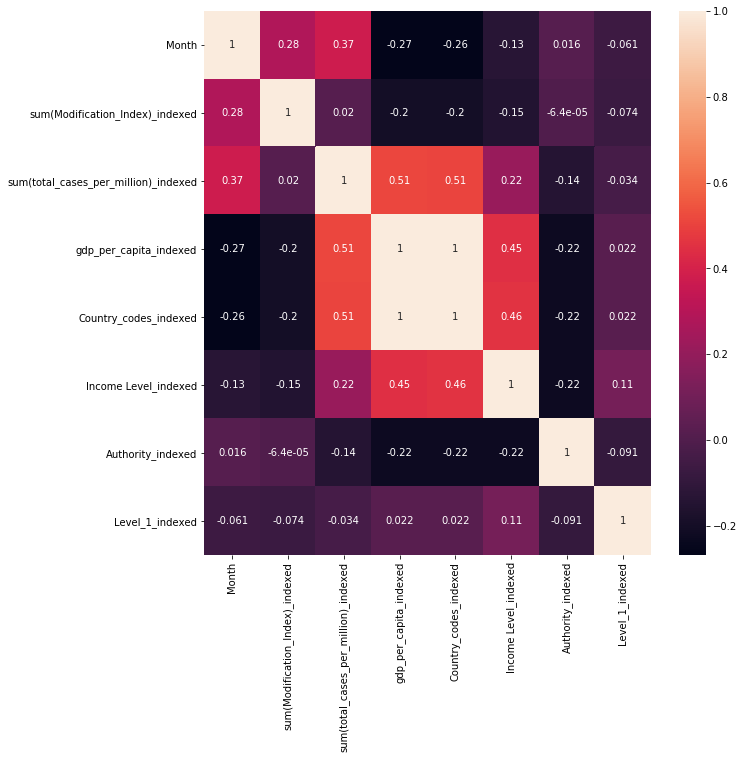

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax = sns.heatmap(df6, annot=True)

INFERENCE: Modifications are highly negatively correlated 3 by the gdp of the country, country and their income levels

7.6. Use pairplot to graph the corealltion between the features in the dataset

Out[95]:

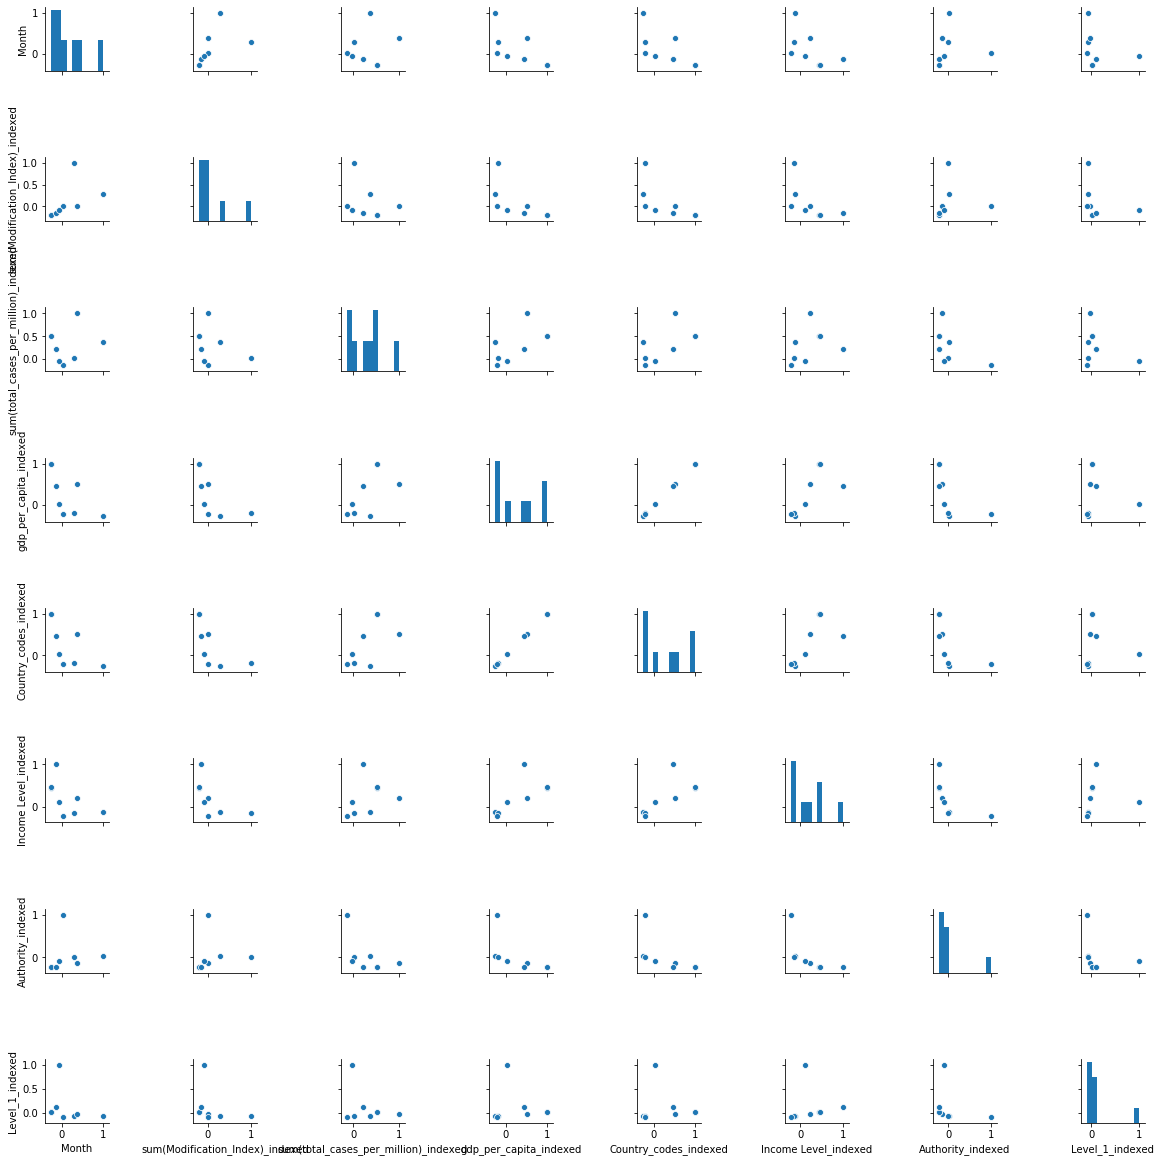

<seaborn.axisgrid.PairGrid at 0x7f1a9d6dab90>

In [0]:
sns.pairplot(df6,height = 2)

7.7 Use one-hot encoding to convert the indexed values into encoded values

 7.8 Use vectore assembler to convert teh featrue columns to vectors 
 
 7.9 Fit both the trasnformation steps using a pipeline

In [0]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
df5 = df5.withColumnRenamed("sum(Modification_Index)_indexed","label")


encoders = OneHotEncoder(inputCols = ["Country_codes_indexed","gdp_per_capita_indexed","Income Level_indexed"], outputCols = ["Country_codes_indexed_vector","gdp_per_capita_indexed_vector","Income Level_indexed_vector"])
assembler = VectorAssembler(inputCols=[encoder for encoder in encoders.getOutputCols()],outputCol="features")


pipeline = Pipeline(stages=[encoders,assembler])
model=pipeline.fit(df5)
transformed = model.transform(df5)
transformed.show(5)


+-----+-----+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+----------------------------+-----------------------------+---------------------------+--------------------+
Month|label|sum(total_cases_per_million)_indexed|gdp_per_capita_indexed|Country_codes_indexed|Income Level_indexed|Authority_indexed|Level_1_indexed| Level_2|Country_codes_indexed_vector|gdp_per_capita_indexed_vector|Income Level_indexed_vector| features|
+-----+-----+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+----------------------------+-----------------------------+---------------------------+--------------------+
 9| 1.0| 524.0| 4.0| 4.0| 1.0| 0.0| 0.0|Prudential ...| (147,[4],[1.0])| (147,[4],[1.0])| (3,[1],[1.0])|(297,[4,151,295],...|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 0.0|Support borrowers...| (147,[83],[1.0])| (147,[85],[1.0])| (3,[],[])|(297,[83,232],[1....|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 2.0|Market functionin...| (147,[83],[1.0])| (147,[85],[1.0])| (3,[],[])|(297,[83,232],[1....|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 3.0|Promoting and ens...| (147,[83],[1.0])| (147,[85],[1.0])| (3,[],[])|(297,[83,232],[1....|
 3| 0.0| 235.0| 85.0| 83.0| 3.0| 0.0| 1.0|Liquidity (incl F...| (147,[83],[1.0])| (147,[85],[1.0])| (3,[],[])|(297,[83,232],[1....|
+-----+-----+------------------------------------+----------------------+---------------------+--------------------+-----------------+---------------+--------------------+----------------------------+-----------------------------+---------------------------+--------------------+
only showing top 5 rows

7.10. Scale features and labels before inputing to the model

In [0]:
# Split the data into training and test sets
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
transformed1 = transformed.select("label","features")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(transformed1)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(transformed1)
(trainingData, testData) = scaledData.randomSplit([0.8, 0.2])

Predict if a certain policy will be modified or not given the country, GDP and Income Level

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt1 = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[dt1])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# compute test error using predictions
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("F1 Measure  = %g " %accuracy)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model
print(treeModel)

+----------+-----+--------------------+
prediction|label| features|
+----------+-----+--------------------+
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
+----------+-----+--------------------+
only showing top 5 rows

F1 Measure = 0.886256 
Test Error = 0.113744 
PipelineModel_890969164632

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=8)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[rf])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions_rf = model.transform(testData)

# Select example rows to display.
predictions_rf.select("prediction", "label", "features").show(5)

# Compute test error usin gpredictions
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")


accuracy = evaluator.evaluate(predictions_rf)
print("Test Error = %g" % (1.0 - accuracy))
print("accuracy = %g " %accuracy)

treeModel = model
# summary only
print(treeModel)


+----------+-----+--------------------+
prediction|label| features|
+----------+-----+--------------------+
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
 0.0| 0.0|(297,[0,147,296],...|
+----------+-----+--------------------+
only showing top 5 rows

Test Error = 0.113744
accuracy = 0.886256 
PipelineModel_44ae4637c637

Below are the inferences and conclusions made from this project

1. USA is the country with maximum no:of modifications
2. The maximum of policy modifications has hapened in the months 4 and 6, ie; April and June. But there is no pattern found globally.
3. There is no impact of total number of cases per month on the number of modifications happened on parent policy of policy 1
4. The authority most popular in the Turkey, India are RES
5. Insolvency is the policy most preferred by people with lower middle income
6. Both the prediction models has an accuracy of 85% and test error rate of 15% because the predictions in our datset is stable. if it was stable random forest would have outperfromed decsison tree accuracy.